In [17]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
sys.path.append('../python/')


import tqdm
import separation

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
def connected_component_subgraphs(G, copy=True):
    ## this function was removed from latest versions of networkx!!
    for c in nx.connected_components(G):
        if copy:
            yield G.subgraph(c).copy()
        else:
            yield G.subgraph(c)

In [8]:
interactome_file = '../data/interactome_2019_merged.csv'
mapping_file = '../data/interactome_2019_merged_protAnnots.csv'
disease_genes_file = '../data/Guney2016_GenesDisease.tsv'

In [6]:
hi = pd.read_csv(interactome_file, index_col = 0)
edges = zip(hi.proteinA, hi.proteinB)
hi = nx.Graph()
hi.add_edges_from(edges)

## consider only LCC
G = list(connected_component_subgraphs(hi))[0]
print (len(G.nodes()), len(G.edges()))

18446 327868


In [12]:
mapping = pd.read_csv(mapping_file,
                     index_col = 0)
symbol2entrez = {i:j for i,j in zip(mapping.Symbol, mapping.GeneID)}

In [13]:
disease2genes = {}
for i in open(disease_genes_file).readlines():
    v = i.rstrip().split('\t')
    disease = v[1]
    genes = v[2:]
    if len(genes) > 19:
        disease2genes[disease] = [int(i) for i in genes]

In [14]:
diseasegenes = list(disease2genes.values())
diseasegenes = sum(diseasegenes, [])
diseasegenes = list(set(diseasegenes))
len(diseasegenes)

3173

In [15]:
dic = {'CEP43':11116, 'MTARC1':64757}
symbol2entrez.update(dic)

In [16]:
dt = pd.read_csv('../data/COVID19_Edges.csv')
dt['entrez'] = [symbol2entrez[i] for i in dt.Human]
dt.head()

,Virus,Human,value,entrez
0,SARS-CoV2 E,AP3B1,1,8546
1,SARS-CoV2 E,BRD4,1,23476
2,SARS-CoV2 E,BRD2,1,6046
3,SARS-CoV2 E,CWC27,1,10283
4,SARS-CoV2 E,ZC3H18,1,124245


# $S_{AB}$

In [ ]:
sab = {}
for disease in tqdm.tqdm(disease2genes.keys()):

#disease = list(disease2genes.keys())[0]
    genes_A = set(dt.entrez) & set(G.nodes())
    genes_B = set(disease2genes[disease]) & set(G.nodes())
    d_A = separation.calc_single_set_distance(G,genes_A)
    d_B = separation.calc_single_set_distance(G,genes_B)

    # distances BETWEEN the two gene sets:
    d_AB = separation.calc_set_pair_distances(G,genes_A,genes_B)

    # calculate separation
    s_AB = d_AB - (d_A + d_B)/2.
    sab[disease] = s_AB

 33%|███▎      | 100/299 [06:55<09:49,  2.96s/it] 

In [85]:
dx = pd.DataFrame.from_dict(sab, orient='index')
dx = dx.reset_index()
dx.columns = ['disease', 'sab']
dx.head()

,disease,sab
0,kidney diseases,0.150809
1,chromosome disorders,0.340531
2,"diabetes mellitus, type 1",0.219150
3,cardiomegaly,0.377554
4,anemia,0.470873


In [89]:
dx.to_csv('../output/tables/sab_virustargets.csv')

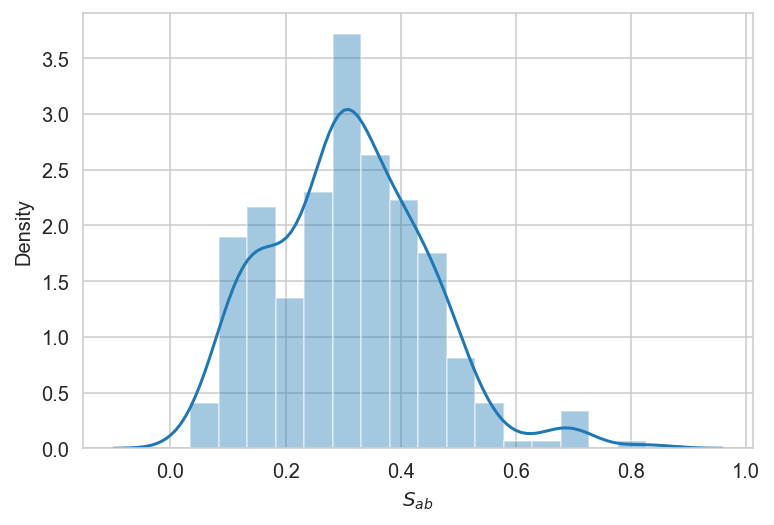

In [92]:
fig, ax = plt.subplots(1,1)
sns.distplot(dx['sab'],ax=ax)
ax.set_xlabel('$S_{ab}$')
ax.set_ylabel('Density')
fig.savefig('../output/tables/sab_virus_dist.png', dpi = 300)